https://www.kaggle.com/datasets/isaienkov/bearing-classification?select=bearing_classes.csv&sort=published

# Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 1
%aimport transformations
%aimport f

from pathlib import Path

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 113

import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.preprocessing import Normalizer, StandardScaler, PowerTransformer

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

RS = 35577 # global random state seed
raw_data_dir_path = './data-raw'

data_csv_path = f'{raw_data_dir_path}/bearing_signals.csv'
lbls_csv_path = f'{raw_data_dir_path}/bearing_classes.csv'

transformations loaded, version: 0.1
framework loaded, version: 0.1


In [2]:
Path(data_csv_path).stat().st_size / 2**20, 'MB'
Path(lbls_csv_path).stat().st_size / 2**20, 'MB'

(1927.1997184753418, 'MB')

(0.000667572021484375, 'MB')

In [3]:
df_data = pd.read_csv(data_csv_path)
df_lbls = pd.read_csv(lbls_csv_path, sep=';', index_col = 'bearing_id')

### Add labels to data

In [4]:
df_data = pd.merge(df_data, df_lbls, left_on='bearing_2_id', right_on='bearing_id')

# First Look

## Lables

In [10]:
df_lbls['status'].value_counts()
df_lbls['status'].value_counts(normalize=True)

0    100
1     13
Name: status, dtype: int64

0    0.884956
1    0.115044
Name: status, dtype: float64

## Data

In [6]:
'DF size in mem MB: ', df_data.memory_usage().sum()/2**20
'shape', df_data.shape
df_data.info(verbose=True)
df_data.describe().T
'isnull', df_data.isnull().sum()

('DF size in mem MB: ', 1174.8161315917969)

('shape', (10265700, 14))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10265700 entries, 0 to 10265699
Data columns (total 14 columns):
 #   Column         Dtype  
---  ------         -----  
 0   experiment_id  int64  
 1   bearing_1_id   int64  
 2   bearing_2_id   int64  
 3   timestamp      float64
 4   a1_x           float64
 5   a1_y           float64
 6   a1_z           float64
 7   a2_x           float64
 8   a2_y           float64
 9   a2_z           float64
 10  rpm            float64
 11  hz             float64
 12  w              float64
 13  status         int64  
dtypes: float64(10), int64(4)
memory usage: 1.1 GB


,count,mean,std,min,25%,50%,75%,max
experiment_id,10265700.0,56.588971,3.231361e+01,1.000000e+00,29.000000,56.000000,85.000000,112.000000
bearing_1_id,10265700.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
bearing_2_id,10265700.0,56.588971,3.231361e+01,1.000000e+00,29.000000,56.000000,85.000000,112.000000
timestamp,10265700.0,15.567967,9.425589e+00,0.000000e+00,7.638000,15.276333,22.914333,55.499667
a1_x,10265700.0,-0.220073,1.824082e+00,-1.604771e+01,-1.041087,-0.175320,0.594250,15.600872
a1_y,10265700.0,-0.048326,1.450662e+00,-1.887183e+01,-0.607370,-0.039563,0.528244,16.142936
a1_z,10265700.0,-0.052549,1.768919e+00,-1.633967e+01,-0.878530,-0.014243,0.850044,16.407213
a2_x,10265700.0,-0.312419,2.553113e+00,-1.765083e+01,-1.602094,-0.374838,0.852418,19.166852
a2_y,10265700.0,-0.087583,2.631378e+00,-1.873959e+01,-1.247228,0.002226,0.867233,22.492407
a2_z,10265700.0,0.071022,2.700098e+00,-2.296248e+01,-1.040389,0.055715,1.151820,25.963643


('isnull',
 experiment_id    0
 bearing_1_id     0
 bearing_2_id     0
 timestamp        0
 a1_x             0
 a1_y             0
 a1_z             0
 a2_x             0
 a2_y             0
 a2_z             0
 rpm              0
 hz               0
 w                0
 status           0
 dtype: int64)

In [7]:
df_data.head(5)

,experiment_id,bearing_1_id,bearing_2_id,timestamp,a1_x,a1_y,a1_z,a2_x,a2_y,a2_z,rpm,hz,w,status
0,1,0,1,0.000000,0.113269,0.149706,-0.110275,-0.186030,0.194450,0.454299,0.0,0.0,0.000006,0
1,1,0,1,0.000333,-0.367713,-0.228832,0.177821,0.285992,0.002226,-0.043930,0.0,0.0,0.000243,0
2,1,0,1,0.000667,0.113269,0.149706,-0.398371,-0.091625,0.002226,0.454299,0.0,0.0,0.000369,0
3,1,0,1,0.001000,-0.175320,-0.228832,-0.110275,0.285992,0.002226,0.255007,0.0,0.0,0.000520,0
4,1,0,1,0.001333,-0.079124,0.055072,-0.110275,0.191588,0.002226,0.255007,0.0,0.0,0.000175,0


In [8]:
'Number of unique experiments: ', df_data['experiment_id'].nunique()

'Number of Unique Bearings in slot 1: ', df_data['bearing_1_id'].nunique()
'bearing_1_id:', df_data.loc[0, 'bearing_1_id']

'Number of Unique Bearings in slot 2: ', df_data['bearing_2_id'].nunique()

'bearing_1_id:',  df_data['bearing_2_id'].unique()

('Number of unique experiments: ', 112)

('Number of Unique Bearings in slot 1: ', 1)

('bearing_1_id:', 0)

('Number of Unique Bearings in slot 2: ', 112)

('bearing_1_id:',
 array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
         66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        105, 106, 107, 108, 109, 110, 111, 112]))

In [9]:
'one experiment is testing one bearing in slot 2?: ', (df_data.groupby(['experiment_id'])['bearing_2_id'].nunique() == 1).all()

('one experiment is testing one bearing in slot 2?: ', True)

## [hz] and [rpm] is the same feature,hz*60 = rpm

In [11]:
df_data[['hz', 'rpm']].corr()

(df_data['hz']*60 == df_data['rpm']).all()
df_data['hz']*60 == df_data['rpm']

,hz,rpm
hz,1.0,1.0
rpm,1.0,1.0


False

0            True
1            True
2            True
3            True
4            True
            ...  
10265695    False
10265696    False
10265697    False
10265698    False
10265699    False
Length: 10265700, dtype: bool

In [12]:
((df_data['hz']*60).round(8) == df_data['rpm'].round(8)).all()

True

## Duplicates

In [13]:
'Do we have duplicates? ', df_data.duplicated().any()

('Do we have duplicates? ', False)

# Visualize Data Distribution

### Hist to be removed

In [ ]:
# df_plt = df_data

# axs = f.get_axes(2, 4).flat
# for ax, col in zip(axs, ['a1_x', 'a1_y', 'a1_z', 'rpm', 'a2_x', 'a2_y', 'a2_z', 'w']):
#     ax_kw = {'bins': 33, 'edgecolor':'gray', 'alpha':0.5, }
#     _ = ax.hist(df_plt.loc[df_plt['status'] == 0, col], label='0', **ax_kw)
#     _ = ax.hist(df_plt.loc[df_plt['status'] == 1, col], label='1', **ax_kw)
#     _ = ax.legend()
#     _ = ax.set_title(col)
#     # _ = ax.ticklabel_format(useOffset=False, style='plain')

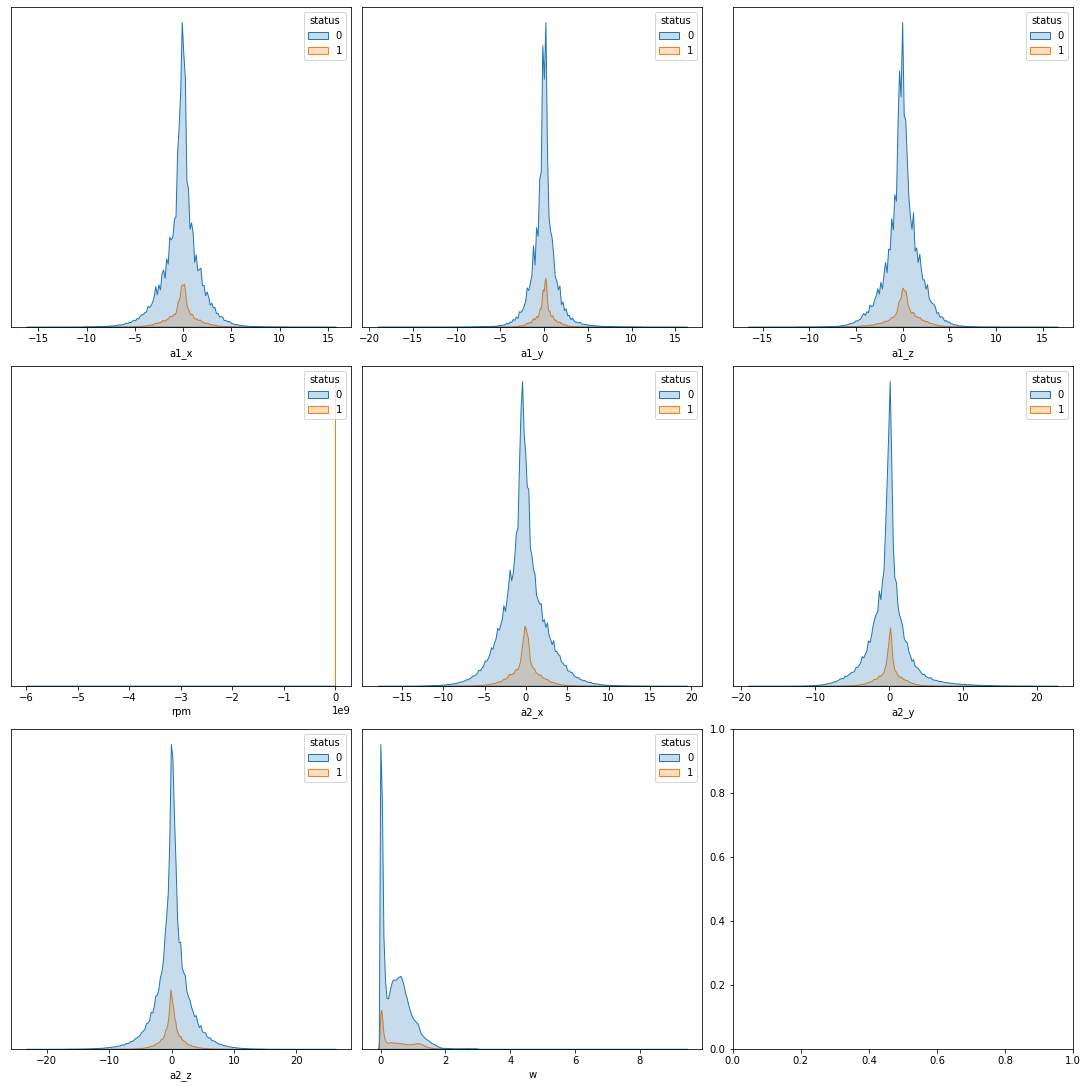

In [15]:
df_plt = df_data
cols = ['a1_x', 'a1_y', 'a1_z', 'rpm', 'a2_x', 'a2_y', 'a2_z', 'w']
axs = f.get_axes(2, 4).flat

for ax, col in zip(axs[:len(cols)], cols):
    _ = sns.kdeplot(ax=ax, data=df_plt, x=col, hue='status', shade=True)
    ax.axes.get_yaxis().set_visible(False)

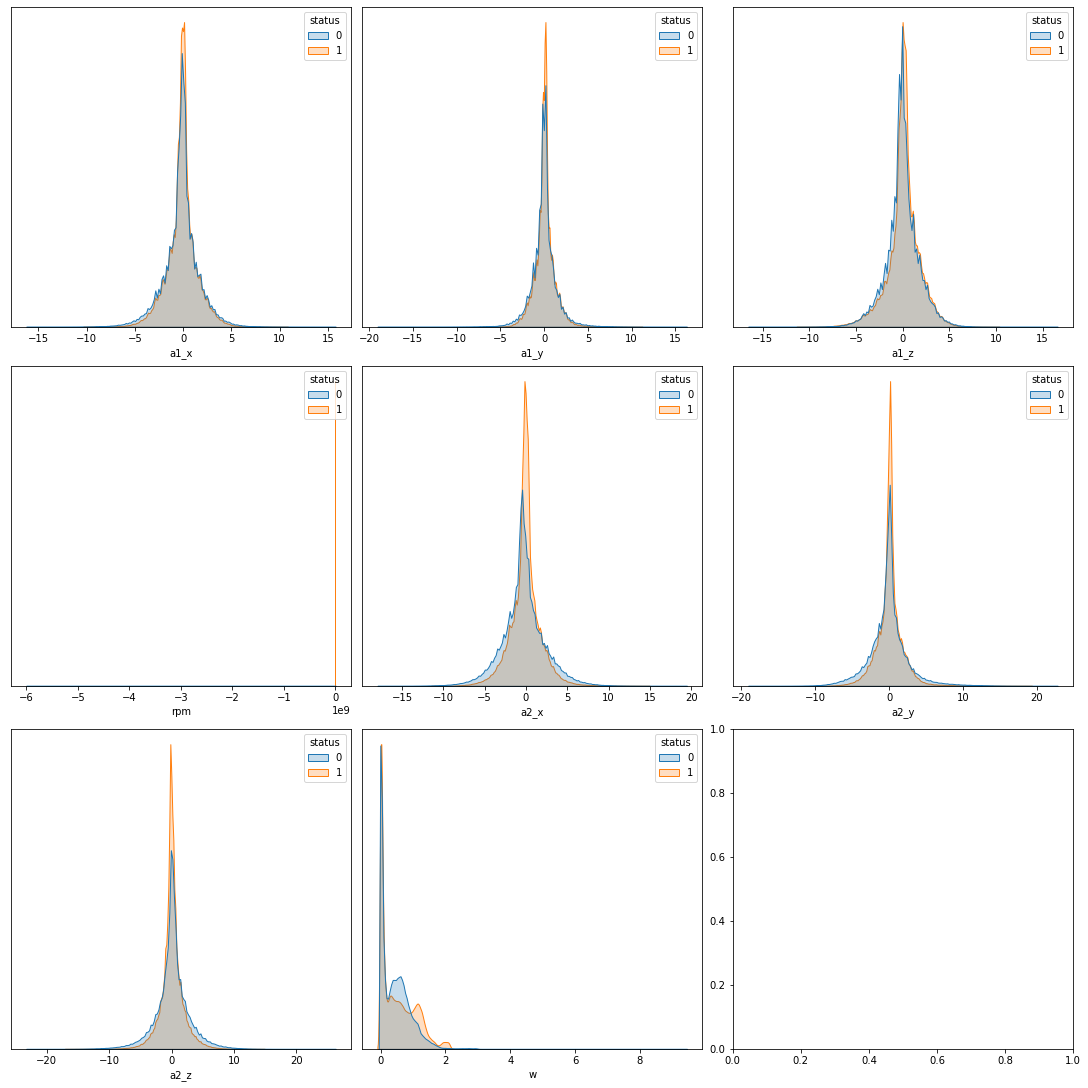

In [16]:
df_plt = df_data
cols = ['a1_x', 'a1_y', 'a1_z', 'rpm', 'a2_x', 'a2_y', 'a2_z', 'w']
axs = f.get_axes(2, 4).flat

for ax, col in zip(axs[:len(cols)], cols):
    _ = sns.kdeplot(ax=ax, data=df_plt, x=col, hue='status', common_norm=False, shade=True)
    ax.axes.get_yaxis().set_visible(False)

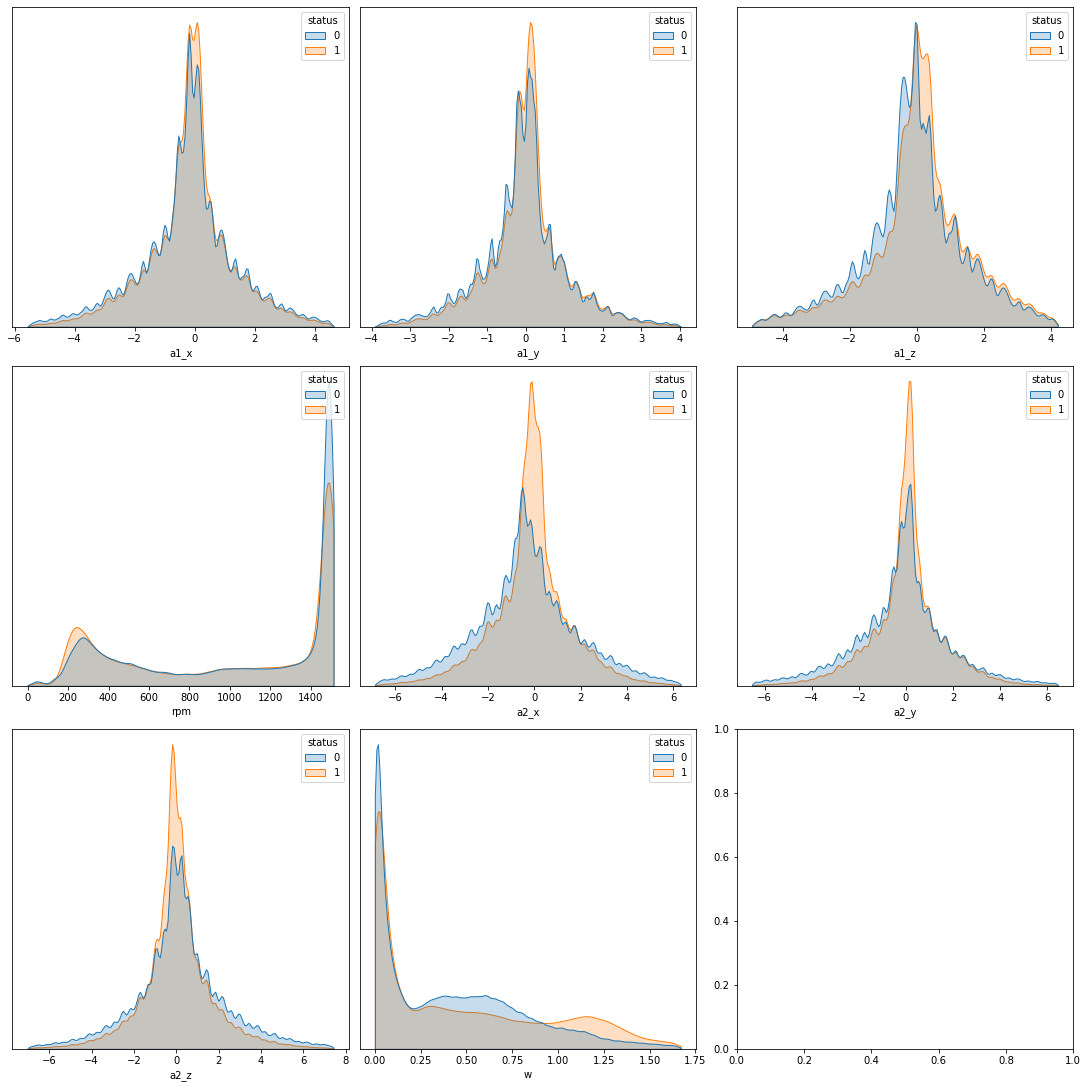

In [17]:
df_plt = df_data
cols = ['a1_x', 'a1_y', 'a1_z', 'rpm', 'a2_x', 'a2_y', 'a2_z', 'w']
axs = f.get_axes(2, 4).flat

for ax, col in zip(axs[:len(cols)], cols):
    p01 = df_plt[col].quantile(0.01)
    p99 = df_plt[col].quantile(0.99)
    df_plt = df_plt.loc[ (p01 < df_plt[col]) & (df_plt[col] < p99) ]
    _ = sns.kdeplot(ax=ax, data=df_plt, x=col, hue='status', common_norm=False, shade=True, clip=(p01, p99))
    ax.axes.get_yaxis().set_visible(False)

# Remove outliers for [rpm]' and [w]

## [rpm] outliers

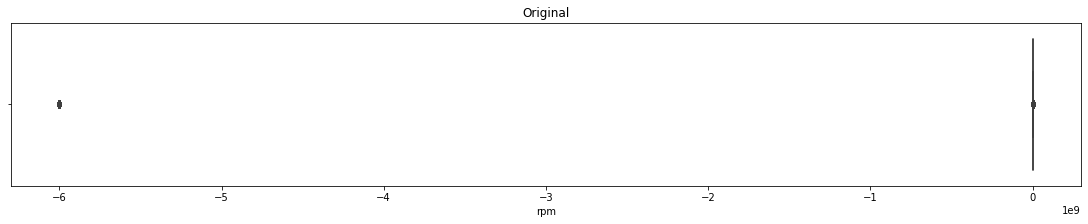

In [19]:
df_plt = df_data['rpm']
_ = sns.boxplot(x=df_plt, orient='w', ax=f.get_ax(1 , 5)).set_title('Original')

In [20]:
df_data.loc[df_data['rpm'] < 0, 'experiment_id'].value_counts()

40    474
Name: experiment_id, dtype: int64

There is a group of 474 low outliers present only for experiment wit id 40. I decide to remove them as negative recorgin negative RPM does not make much sense. The RPM value should still be positibe even if the rotation is in oposite direction.

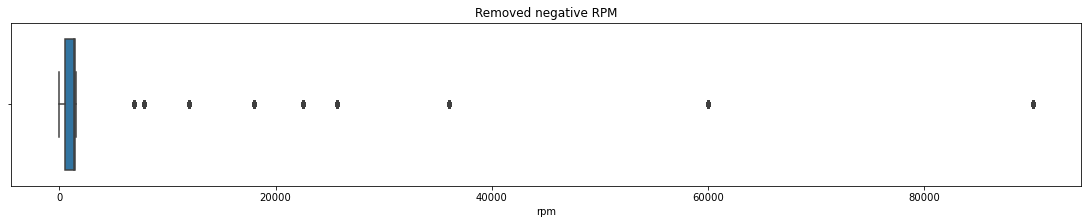

In [21]:
df_plt = df_data.loc[df_data['rpm'] > 0, 'rpm']
_ = sns.boxplot(x=df_plt, orient='w', ax=f.get_ax(1 , 5)).set_title('Removed negative RPM')

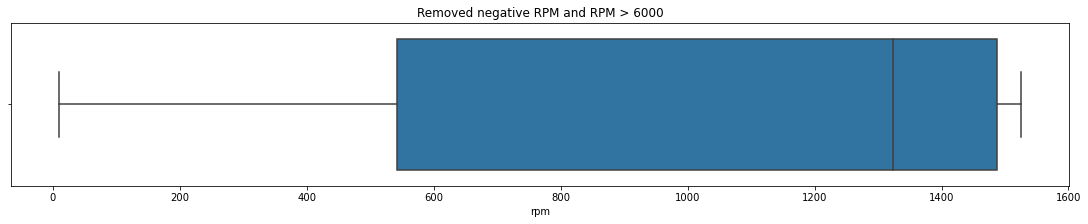

In [22]:
df_plt = df_data.loc[ (df_data['rpm'] > 0) & (df_data['rpm'] < 6000), 'rpm']
_ = sns.boxplot(x=df_plt, orient='w', ax=f.get_ax(1 , 5)).set_title('Removed negative RPM and RPM > 6000')

In [23]:
'# outliers > 6000: ', len(df_data.loc[ (df_data['rpm'] > 0) & (df_data['rpm'] > 6000), 'rpm'])
'% outliers > 6000: ', len(df_data.loc[ (df_data['rpm'] > 0) & (df_data['rpm'] > 6000), 'rpm'])/len(df_data)

'how are they distributed across experiments? :',
df_data.loc[ (df_data['rpm'] > 0) & (df_data['rpm'] > 6000), 'experiment_id'].value_counts()
df_data.loc[ (df_data['rpm'] > 0) & (df_data['rpm'] > 6000), 'experiment_id'].value_counts(normalize=True)

('# outliers > 6000: ', 4599)

('% outliers > 6000: ', 0.00044799672696455185)

('how are they distributed across experiments? :',)

24    659
21    545
19    484
8     482
15    425
36    384
11    372
81    343
14    273
17    243
23    202
29    187
Name: experiment_id, dtype: int64

24    0.143292
21    0.118504
19    0.105240
8     0.104805
15    0.092411
36    0.083496
11    0.080887
81    0.074581
14    0.059361
17    0.052838
23    0.043923
29    0.040661
Name: experiment_id, dtype: float64

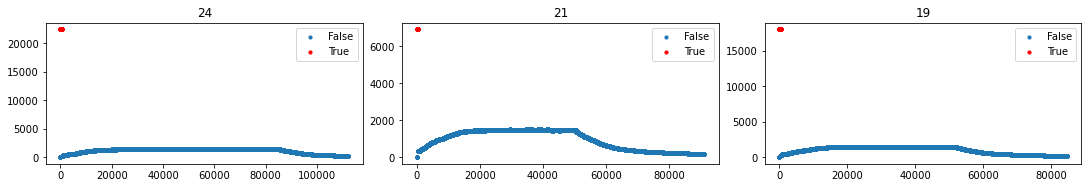

In [53]:
axs = f.get_axes(1, 3, 1, 2).flat

for i_expl, exp_id in enumerate([24, 21, 19]):
    df_plt = df_data.loc[df_data['experiment_id'] == exp_id, 'rpm'].reset_index(drop=True)
    
    _ = axs[i_expl].scatter(df_plt.loc[df_plt<6000].index, df_plt.loc[df_plt<6000].values, label='False', s=10)
    _ = axs[i_expl].scatter(df_plt.loc[df_plt>6000].index, df_plt.loc[df_plt>6000].values, label='True', c='r', s=10)
    _ = axs[i_expl].set_title(exp_id)
    _ = axs[i_expl].legend()

## [w] outliers

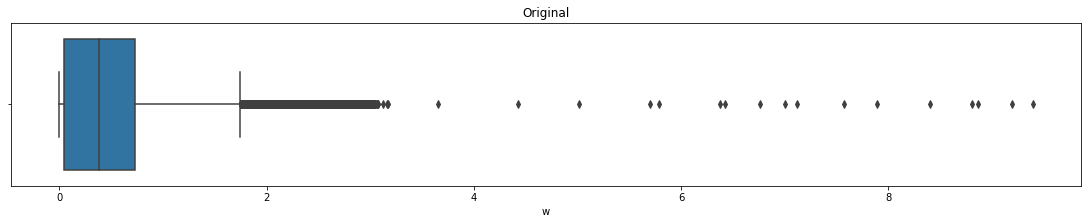

In [25]:
df_plt = df_data['w']
_ = sns.boxplot(x=df_plt, orient='w', ax=f.get_ax(1 ,5)).set_title('Original')

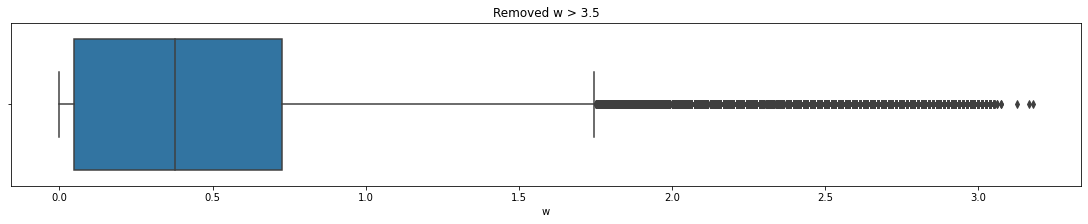

In [26]:
df_plt = df_data.loc[df_data['w'] < 3.5, 'w']
_ = sns.boxplot(x=df_plt, orient='w', ax=f.get_ax(1, 5)).set_title('Removed w > 3.5')

In [27]:
len(df_data.loc[df_data['w'] > 3.5, 'w'])
df_data.loc[df_data['w'] > 3.5, 'experiment_id'].value_counts()

17

39    17
Name: experiment_id, dtype: int64

In [28]:
w_iqr = df_data['w'].quantile(0.75) - df_data['w'].quantile(0.25)
w_iqr

w_outlier_15iqr_upper = df_data['w'].quantile(0.75)+1.5*w_iqr
w_outlier_15iqr_upper

0.6793247165451893

1.7460941483020098

In [29]:
outliers = df_data.loc[df_data['w'] > w_outlier_15iqr_upper, 'experiment_id']
len(outliers)
outliers.value_counts().head(10)
outliers.value_counts(normalize=True).head(10)

125736

20     87694
104    27999
25      5960
24      1530
30       768
21       509
27       267
80       260
26       203
105      175
Name: experiment_id, dtype: int64

20     0.697445
104    0.222681
25     0.047401
24     0.012168
30     0.006108
21     0.004048
27     0.002123
80     0.002068
26     0.001614
105    0.001392
Name: experiment_id, dtype: float64

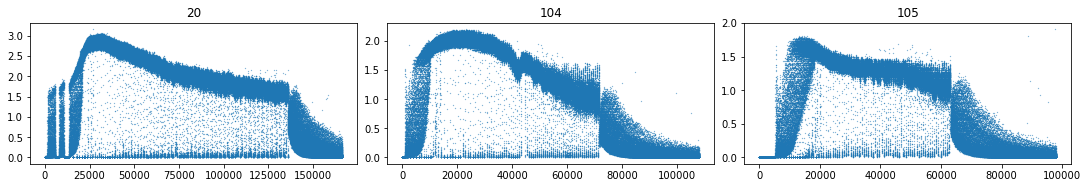

In [30]:
axs = f.get_axes(1, 3, 1, 2).flat

for i_expl, exp_id in enumerate([20, 104, 105]):
    df_plt = df_data.loc[df_data['experiment_id'] == exp_id, 'w'].reset_index(drop=True)
    _ = axs[i_expl].scatter(df_plt.index, df_plt.values, s=0.05)
    _ = axs[i_expl].set_title(f'{exp_id} - w)

looks like some experiments have higher threashold for 'w' usage

# Creating processed, clean data

In [6]:
df_data_noout = df_data.drop('hz', axis=1)
df_data_noout = transformations.drop_rpm_outliers(df_data_noout)
df_data_noout = transformations.drop_w_outliers(df_data_noout)
df_data_noout = transformations.drop_idle_rpm(df_data_noout)

df_data_noout.shape
df_data_noout.columns

(9893842, 13)

Index(['experiment_id', 'bearing_1_id', 'bearing_2_id', 'timestamp', 'a1_x',
       'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z', 'rpm', 'w', 'status'],
      dtype='object')

In [7]:
f.to_pkl(df_data_noout, 'data-processed/data_clean.data.pkl')

## Visualize Data Distribution without outliers

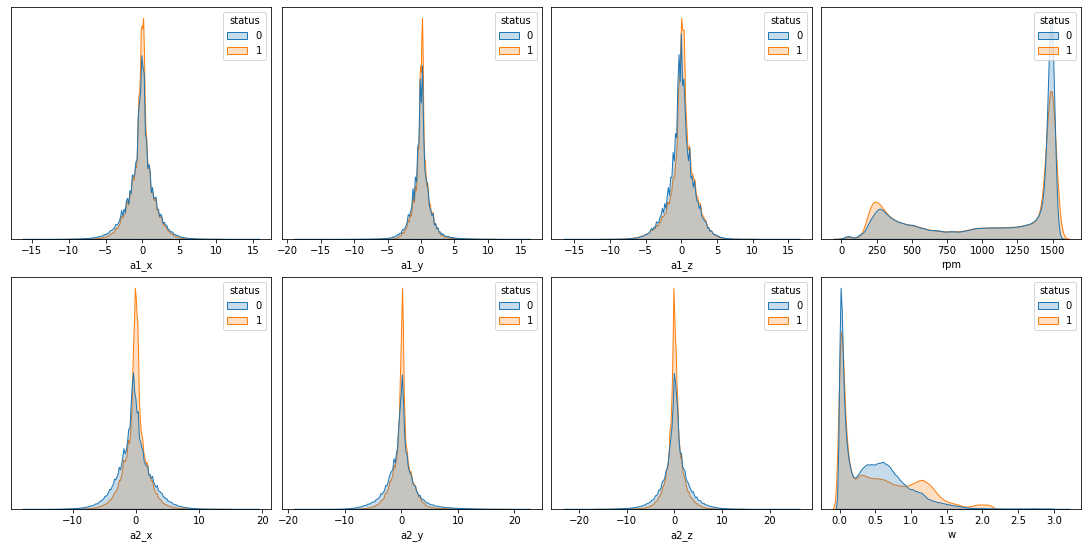

In [56]:
df_plt = df_data_noout
cols = ['a1_x', 'a1_y', 'a1_z', 'rpm', 'a2_x', 'a2_y', 'a2_z', 'w']
axs = f.get_axes(2, 4).flat

for ax, col in zip(axs[:len(cols)], cols):
    _ = sns.kdeplot(ax=ax, data=df_plt, x=col, hue='status', common_norm=False, shade=True)
    ax.axes.get_yaxis().set_visible(False)

In [ ]:
df_plt = df_data_noout
cols = ['a1_x', 'a1_y', 'a1_z', 'rpm', 'a2_x', 'a2_y', 'a2_z', 'w']
axs = f.get_axes(2, 4).flat

for ax, col in zip(axs[:len(cols)], cols):
    p01 = df_plt[col].quantile(0.01)
    p99 = df_plt[col].quantile(0.99)
    df_plt = df_plt.loc[ (p01 < df_plt[col]) & (df_plt[col] < p99) ]
    _ = sns.kdeplot(ax=ax, data=df_plt, x=col, hue='status', common_norm=False, shade=True, clip=(p01, p99))
    ax.axes.get_yaxis().set_visible(False)

## Pair Plot

In [60]:
exp_id_balanced_sampl = df_data_noout[['experiment_id', 'status']].groupby(['status']).sample(12)['experiment_id'].values
df_plt = df_data_noout.loc[df_data_noout['experiment_id'].isin(exp_id_balanced_sampl)].groupby('experiment_id').sample(5000, random_state=RS)

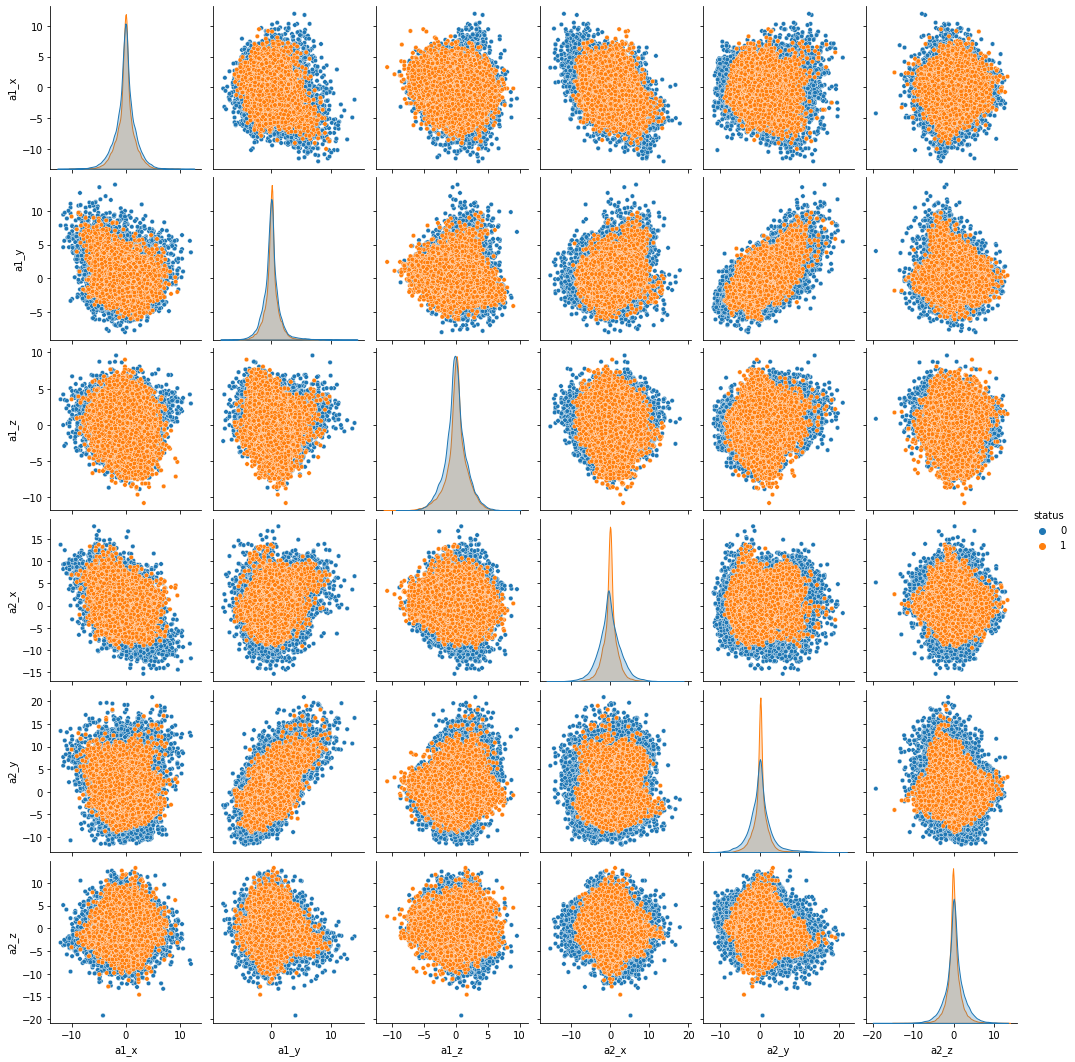

In [67]:
plot_kws = {'s': 20}

vars_ = ['a1_x', 'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z']
_ = sns.pairplot(data=df_plt, vars = vars_, hue='status', plot_kws=plot_kws).fig.set_size_inches(15,15)

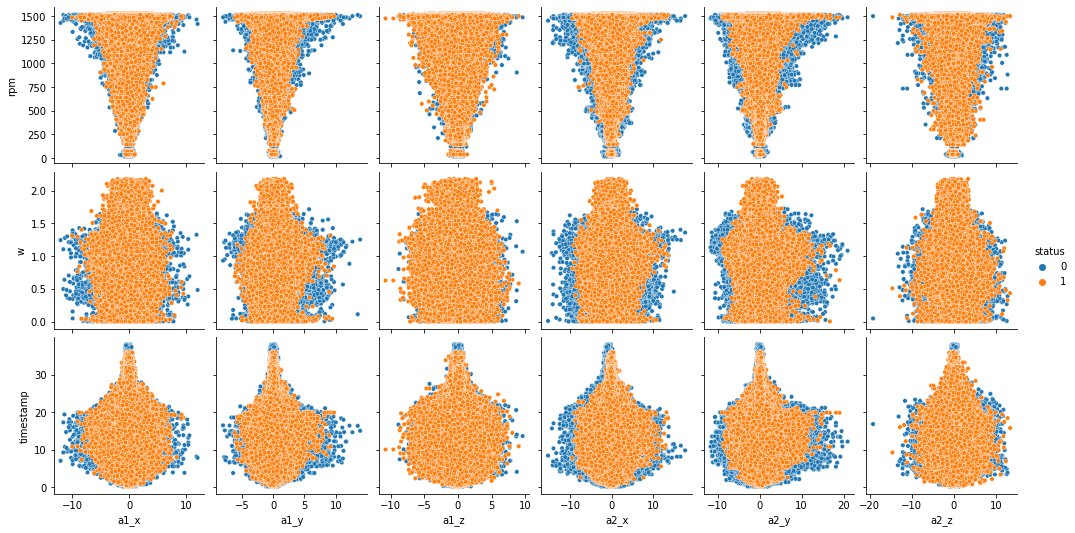

In [70]:
x_vars_ = ['a1_x', 'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z']
y_vars_ = ['rpm', 'w', 'timestamp']
_ = sns.pairplot(data=df_plt, x_vars = x_vars_, y_vars = y_vars_, hue='status', plot_kws=plot_kws).fig.set_size_inches(15,15/2)

## 2D KDE

In [ ]:
exp_id_balanced_sampl = df_data_noout[['experiment_id', 'status']].groupby(['status']).sample(6)['experiment_id'].values
df_plt = df_data_noout.loc[df_data_noout['experiment_id'].isin(exp_id_balanced_sampl)].groupby('experiment_id').sample(5000, random_state=RS)

vars_ = ['a1_x', 'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z']
_ = sns.pairplot(data=df_plt, vars = vars_, hue='status', kind='kde').fig.set_size_inches(15,15)

In [ ]:
x_vars_ = ['a1_x', 'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z']
y_vars_ = ['rpm', 'w', 'timestamp']
_ = sns.pairplot(data=df_plt, x_vars = x_vars_, y_vars = y_vars_, hue='status', kind='kde').fig.set_size_inches(15,15/2)

# Correlation

In [ ]:
df_data_noout.loc[:,['a1_x', 'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z', 'rpm', 'w', 'status']].corr().style.background_gradient(cmap='coolwarm').format(precision=1)

In [ ]:
df_data_noout.loc[df_data_noout['status'] == 0, ['a1_x', 'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z', 'rpm', 'w']].corr().style.background_gradient(cmap='coolwarm').format(precision=1)

In [ ]:
df_data_noout.loc[df_data_noout['status'] == 1, ['a1_x', 'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z', 'rpm', 'w']].corr().style.background_gradient(cmap='coolwarm').format(precision=1)

## Correlation for 1 experiment

In [ ]:
df_data_noout.loc[df_data_noout['experiment_id'] == 1, ['a1_x', 'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z', 'rpm', 'w']].corr().style.background_gradient(cmap='coolwarm').format(precision=1)

In [ ]:
df_data_noout.loc[df_data_noout['experiment_id'] == 112, ['a1_x', 'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z', 'rpm', 'w']].corr().style.background_gradient(cmap='coolwarm').format(precision=1)

## How std of xyz affects status

In [ ]:
df_xyz_std = df_data_noout.groupby(['experiment_id'])[['a1_x', 'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z']].agg(np.std)

df_xyz_std = pd.merge(df_xyz_std, df_lbls, left_on='experiment_id', right_on='bearing_id')

df_xyz_std.head()

In [ ]:
df_xyz_std.corr().style.background_gradient(cmap='coolwarm').format(precision=1)

# Visualize a single experiment

In [ ]:
axs = f.get_axes(8, 1, 1, 8).flat

df_plt = df_data_noout.loc[df_data_noout['experiment_id'] == 1, ['rpm', 'w', 'a1_x', 'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z', 'timestamp']]
transformations.plt_8_params_for_experiment(df_plt, axs, 1)

In [ ]:
axs = f.get_axes(8, 1, 1, 8).flat

df_plt = df_data_noout.loc[df_data_noout['experiment_id'] == 112, ['rpm', 'w', 'a1_x', 'a1_y', 'a1_z', 'a2_x', 'a2_y', 'a2_z', 'timestamp']]
transformations.plt_8_params_for_experiment(df_plt, axs, 112)

In [ ]:
# expid_to_plot = sorted(df_data['experiment_id'].unique())
expid_to_plot = list(range(1,4))

axs = f.get_axes(len(expid_to_plot)*2, 4, 1, 2)

for exp_i, exp_id in enumerate(expid_to_plot):
    df_plt = df_data_noout.loc[df_data_noout['experiment_id'] == exp_id].sample(25000, random_state=RS) # 20k ~20-23%of data
    axs_ = axs[2*exp_i : 2*exp_i +2].flat
    transformations.plt_8_params_for_experiment(df_plt, axs_, exp_id)